In [65]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric

In [74]:
def simulate_data(T, alpha, beta, gamma, theta):
    np.random.seed(123)
    X = np.zeros(T)
    Y = np.zeros(T)

    # Generate X values from N(0, 1)
    X[0] = np.random.normal(0, 1)

    # Generate Y values
    for t in range(1, T):
        epsilon_t = np.random.randn()
        epsilon_t_lag = np.roll(epsilon_t, 1)
        X[t] = np.random.normal(0, 1)
        Y[t] = alpha + beta * Y[t - 1] + gamma * X[t] + epsilon_t + theta * epsilon_t_lag

    return pd.DataFrame({'X': X, 'Y': Y})

# Set the parameters for each quantile level
quantiles = [0.1, 0.5, 0.9]
parameters = {
    0.1: {'alpha': -0.2, 'beta': 0.3, 'gamma': 0.2, 'theta': 0.9},
    0.5: {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3, 'theta': 0.9},
    0.9: {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.4, 'theta': 0.9}}

T = 334

df = pd.DataFrame()

# Simulate data for each quantile level and concatenate into a single DataFrame
for quantile in quantiles:
    params = parameters[quantile]
    data = simulate_data(T, params['alpha'], params['beta'], params['gamma'], params['theta'])
    df = pd.concat([df, data], ignore_index=True)
print(df)


             X         Y
0    -1.085631  0.000000
1     0.282978  1.751552
2    -0.578600 -2.652214
3    -2.426679  1.656729
4     1.265936 -0.264728
...        ...       ...
997  -2.187086 -0.074237
998  -1.271747  0.128640
999  -0.679828  1.837661
1000 -0.008903  0.733277
1001 -0.169744  2.143205

[1002 rows x 2 columns]


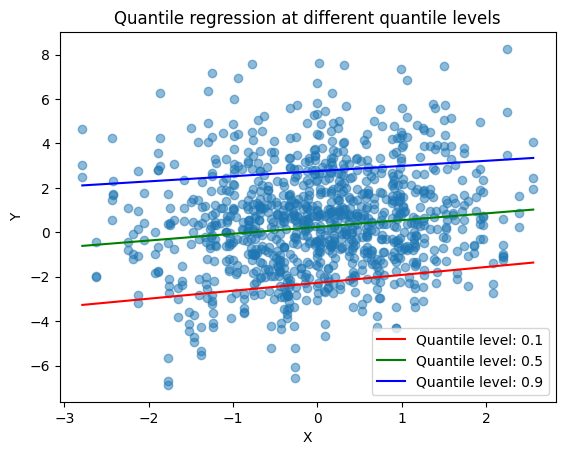

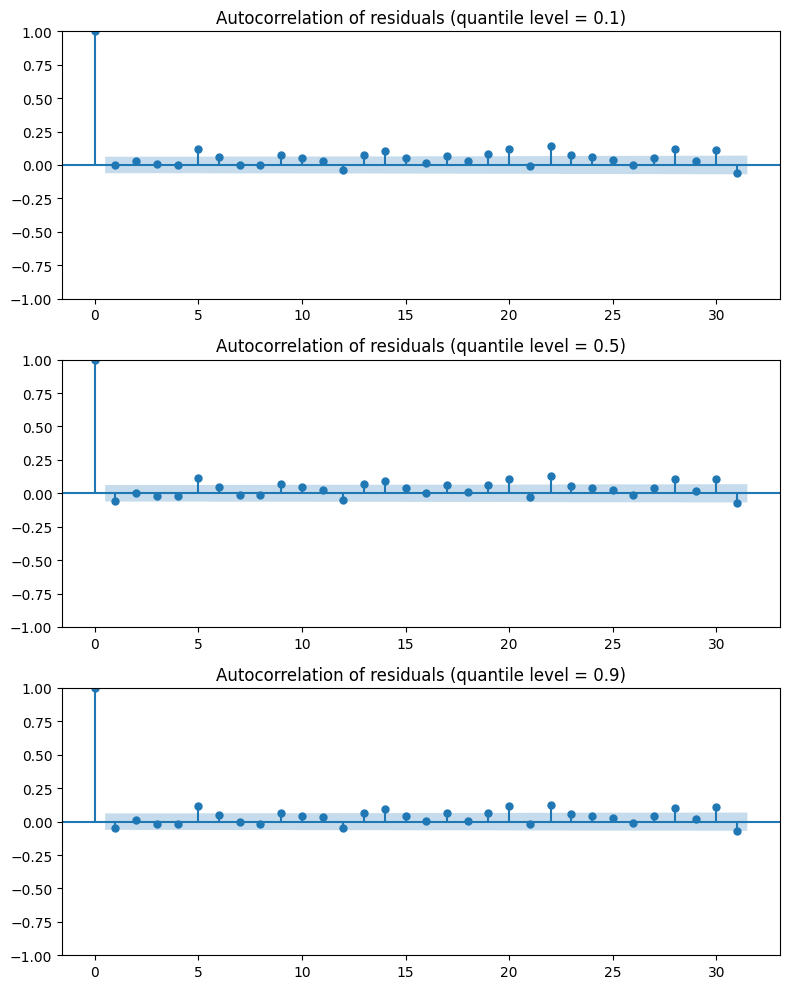

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.1422
 Model:                       QuantReg   Bandwidth:                      0.7732
 Method:                 Least Squares   Sparsity:                        11.28
 Date:                Sat, 24 Jun 2023   No. Observations:                 1002
 Time:                        16:06:17   Df Residuals:                      999
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -2.2763      0.108    -20.990      0.000      -2.489      -2.064
 x1             0.5197      0.034     15.483      0.000       0.454       0.586
 x2             0.3564      0.097      3.668      0.000       0.166   

In [75]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['Y'].values.astype(float)
    x = df['X'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 250)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

fit_quantile(df)

In [ ]:
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313

In [76]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [77]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.2526742480462547]
OLS beta_hat:  [0.45893765600712555]
OLS gamma_hat:  [0.35538915887210537]
OLS theta_hat:  [0.9999999999999997]
GLS alpha_hat:  [0.23859574007303636]
GLS beta_hat:  [0.4888490777272514]
GLS gamma_hat:  [0.3565230198709536]
GLS theta_hat:  [1.000000000000002]
OLS_bias_param_0 = -0.0527
OLS_bias_param_1 = 0.0411
OLS_bias_param_2 = -0.0554
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0662
GLS_bias_param_0 = -0.0386
GLS_bias_param_1 = 0.0112
GLS_bias_param_2 = -0.0565
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0608


In [78]:
def Laplace_estimation(df, p, M, params0, actuals):

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

        #ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))

    def log_l_Asym_Lap(params, X, y):
        α, β, γ = params  # Separate the parameters
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1 - p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2 * p) / p * (1 - p)
        
        # Calculate the log-likelihood
        ll -= np.sum(np.log(np.sqrt(τ_2) * np.sqrt(z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        
        return -ll

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        #params0 = np.array([0.2, 0.5, 0.3], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1
        
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix


In [81]:
#Estimation at p=0.5 and T=100
params0 = np.array([0.2, 0.5, 0.3], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 100, params0, actuals)

Beta Matrix:
[[0.19738369 0.49592787 0.30169946]
 [0.21000181 0.49999291 0.30000923]
 [0.20166667 0.52291667 0.29625   ]
 [0.20159318 0.50655174 0.30661157]
 [0.20700712 0.50846635 0.28918396]
 [0.2041551  0.49519517 0.31737003]
 [0.20875    0.503125   0.298125  ]
 [0.20058698 0.51721263 0.3021011 ]
 [0.1931996  0.52706097 0.31636214]
 [0.1900162  0.51248078 0.31500872]
 [0.2        0.51250002 0.29749999]
 [0.20011138 0.50080714 0.29937478]
 [0.19050292 0.50284535 0.31419227]
 [0.2068321  0.48475958 0.31027537]
 [0.20354167 0.50862269 0.29364583]
 [0.20497601 0.51249932 0.30760555]
 [0.19666667 0.52500002 0.31499999]
 [0.20096957 0.50038399 0.29187247]
 [0.19922405 0.51619285 0.30534071]
 [0.19782082 0.49489182 0.31706699]
 [0.20354166 0.49790183 0.2977799 ]
 [0.1999926  0.50003394 0.30002876]
 [0.19702914 0.49967623 0.31477532]
 [0.198784   0.52005751 0.29212565]
 [0.20689972 0.51735418 0.30899975]
 [0.20770833 0.50364583 0.3009375 ]
 [0.2091242  0.49672429 0.28689926]
 [0.19989583 0.

In [82]:
#Estimation at p=0.5 and T=250
params0 = np.array([0.2, 0.5, 0.3], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 250, params0, actuals)

Beta Matrix:
[[0.20293294 0.51510145 0.29398492]
 [0.20647974 0.47778125 0.29639829]
 [0.20398148 0.49652778 0.31097222]
 [0.20391866 0.50400965 0.29430734]
 [0.20421473 0.51743773 0.30216366]
 [0.20890539 0.49054037 0.30990869]
 [0.2015641  0.47376407 0.29937612]
 [0.2        0.5        0.3       ]
 [0.20825339 0.51055163 0.3099113 ]
 [0.2000463  0.5000217  0.31490017]
 [0.19527778 0.51736111 0.31041667]
 [0.19922325 0.52527006 0.28979167]
 [0.19980713 0.52467166 0.29990586]
 [0.20388889 0.52268518 0.27361111]
 [0.20152778 0.50173611 0.31229167]
 [0.20231481 0.50439815 0.30347222]
 [0.20594694 0.51128555 0.29458869]
 [0.21028927 0.50073447 0.29947844]
 [0.20166665 0.50416666 0.29625002]
 [0.20444473 0.51736213 0.28624951]
 [0.18       0.525      0.315     ]
 [0.19972222 0.49803241 0.31694444]
 [0.20815154 0.51649091 0.285871  ]
 [0.19975861 0.50149714 0.31473679]
 [0.2        0.525      0.3       ]
 [0.20744213 0.50636574 0.30013021]
 [0.21025926 0.50117276 0.29997568]
 [0.19458249 0.

In [79]:
#Estimation at p=0.5 and T=1000
params0 = np.array([0.2, 0.5, 0.3], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 1000, params0, actuals)

Beta Matrix:
[[0.19742753 0.50551687 0.31022413]
 [0.20739326 0.48094136 0.30734858]
 [0.205762   0.50614001 0.31459383]
 ...
 [0.20006976 0.49994803 0.31499215]
 [0.20693219 0.49126202 0.29579652]
 [0.20004959 0.49995106 0.307512  ]]

RMSE Matrix:
[[0.00686989 0.00686989 0.00686989]
 [0.01254185 0.01254185 0.01254185]
 [0.00972763 0.00972763 0.00972763]
 ...
 [0.00865587 0.00865587 0.00865587]
 [0.00688178 0.00688178 0.00688178]
 [0.00433724 0.00433724 0.00433724]]

Successful optimizations: 0
Unsuccessful optimizations: 1000

Mean of Betas:
[0.20252825 0.50464076 0.30448829]

Mean of RMSE:
0.010274393562761464


In [83]:
#Estimation at p=0.1 and T=100
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 100, params0, actuals)

Beta Matrix:
[[-0.19800926  0.30534722  0.19986111]
 [-0.20610318  0.30015475  0.20124232]
 [-0.2         0.31125002  0.2       ]
 [-0.19863246  0.30394805  0.19986933]
 [-0.20888889  0.30083333  0.19166667]
 [-0.20472222  0.30958333  0.20472222]
 [-0.19958334  0.31229166  0.20069445]
 [-0.20913111  0.30616961  0.19776811]
 [-0.19336082  0.30703303  0.21272731]
 [-0.20498846  0.31499317  0.20500069]
 [-0.205       0.2925      0.205     ]
 [-0.20669062  0.2850149   0.20665536]
 [-0.21968453  0.2804558   0.20117076]
 [-0.2         0.3075      0.205     ]
 [-0.21111111  0.29166667  0.19333333]
 [-0.20475997  0.30683719  0.20561895]
 [-0.204444    0.30388266  0.21926151]
 [-0.19050275  0.31221246  0.20558377]
 [-0.20020834  0.31031254  0.20354158]
 [-0.20146834  0.29636088  0.21005963]
 [-0.20178241  0.30600694  0.20082562]
 [-0.199955    0.29997917  0.20003405]
 [-0.19865446  0.3230195   0.20053611]
 [-0.20308418  0.30854289  0.19811117]
 [-0.20638238  0.28545898  0.20619141]
 [-0.2074475

In [84]:
#Estimation at p=0.1 and T=250
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 250, params0, actuals)

Beta Matrix:
[[-0.20495865  0.31512967  0.18814706]
 [-0.19759259  0.28666667  0.20648148]
 [-0.2010447   0.3040642   0.20603656]
 [-0.20593399  0.30033908  0.19778958]
 [-0.20347222  0.30583334  0.20041667]
 [-0.20748657  0.2910601   0.21060652]
 [-0.20195473  0.29157407  0.1944856 ]
 [-0.20164166  0.30247078  0.19753343]
 [-0.2005479   0.31414588  0.20068568]
 [-0.19763374  0.29511574  0.20963992]
 [-0.20497827  0.31750409  0.20333324]
 [-0.2         0.3075      0.20125   ]
 [-0.21158332  0.31424152  0.19438323]
 [-0.19998517  0.30005805  0.20000977]
 [-0.2         0.3         0.21      ]
 [-0.21217352  0.30593411  0.20367447]
 [-0.21268519  0.30902778  0.19740741]
 [-0.20993108  0.30006172  0.1999823 ]
 [-0.19156216  0.31482811  0.19539259]
 [-0.20682884  0.28786218  0.20518225]
 [-0.17929028  0.31669708  0.21344946]
 [-0.20319433  0.29604194  0.21236139]
 [-0.20665731  0.3099884   0.19001343]
 [-0.20005871  0.30195146  0.20754665]
 [-0.19529921  0.31545653  0.20555127]
 [-0.2088541

In [80]:
#Estimation at p=0.1 and T=1000
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 1000, params0, actuals)

Beta Matrix:
[[-0.20236148  0.29946978  0.2093926 ]
 [-0.20958263  0.28688598  0.20709081]
 [-0.20093672  0.30095698  0.21870555]
 ...
 [-0.20000656  0.30007423  0.20999817]
 [-0.20169886  0.29943287  0.20419854]
 [-0.19757161  0.30363607  0.20754557]]

RMSE Matrix:
[[0.00559996 0.00559996 0.00559996]
 [0.01023204 0.01023204 0.01023204]
 [0.01082729 0.01082729 0.01082729]
 ...
 [0.00577261 0.00577261 0.00577261]
 [0.00263537 0.00263537 0.00263537]
 [0.005035   0.005035   0.005035  ]]

Successful optimizations: 0
Unsuccessful optimizations: 1000

Mean of Betas:
[-0.20259012  0.30318062  0.2025391 ]

Mean of RMSE:
0.006901893812261253


In [85]:
#Estimation at p=0.9 and T=100
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 100, params0, actuals)

Beta Matrix:
[[0.61589799 0.69420536 0.39603169]
 [0.62999999 0.7        0.4       ]
 [0.58250027 0.71652713 0.41277802]
 [0.58821751 0.68573106 0.41214661]
 [0.61967825 0.71298638 0.38452465]
 [0.56743027 0.71398812 0.42506875]
 [0.62625    0.704375   0.3975    ]
 [0.60213459 0.73449477 0.39918701]
 [0.57998702 0.73892279 0.42219301]
 [0.57503158 0.71359031 0.42780502]
 [0.61333295 0.67601842 0.40407443]
 [0.59976735 0.70069549 0.3999112 ]
 [0.60491744 0.71353807 0.41758032]
 [0.62048062 0.67891127 0.41393601]
 [0.61796875 0.70929688 0.39989583]
 [0.61517269 0.71739676 0.40977777]
 [0.59477725 0.71917062 0.41989014]
 [0.60339785 0.73805424 0.39327382]
 [0.60101563 0.72378906 0.40776042]
 [0.60032385 0.689964   0.4264669 ]
 [0.578996   0.72557734 0.37857142]
 [0.61273426 0.68359828 0.38596261]
 [0.60525442 0.68534801 0.41682076]
 [0.56743761 0.73560025 0.40167089]
 [0.61895072 0.72218986 0.41430248]
 [0.626875   0.70072917 0.40125   ]
 [0.64867997 0.69156935 0.38918287]
 [0.60203416 0.

In [86]:
#Estimation at p=0.9 and T=250
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 250, params0, actuals)

Beta Matrix:
[[0.63090278 0.73896992 0.39263886]
 [0.6248992  0.62467012 0.41506447]
 [0.53975304 0.75031561 0.40768167]
 [0.61492872 0.70478121 0.38902737]
 [0.60587804 0.73010961 0.38664406]
 [0.63209487 0.71466514 0.41966713]
 [0.59297042 0.7082994  0.41464599]
 [0.6        0.7        0.4       ]
 [0.62687757 0.69236025 0.39997599]
 [0.59993164 0.70001139 0.42005859]
 [0.58833368 0.72722202 0.40555574]
 [0.60312071 0.70589735 0.4058299 ]
 [0.59833526 0.73631955 0.40090964]
 [0.61166667 0.73175926 0.36481481]
 [0.601875   0.7021875  0.41625   ]
 [0.60694444 0.70615741 0.40462963]
 [0.6112591  0.70441849 0.40744887]
 [0.63116911 0.69868296 0.39957483]
 [0.59250005 0.70583329 0.40333333]
 [0.61749821 0.72041641 0.38250014]
 [0.58       0.68055556 0.42222222]
 [0.60136574 0.69975694 0.42115741]
 [0.61808886 0.69928108 0.40043102]
 [0.59999573 0.70002825 0.42001126]
 [0.6        0.735      0.4       ]
 [0.6221875  0.70875    0.39989583]
 [0.60317202 0.70131056 0.4082302 ]
 [0.62038128 0.

In [88]:
#Estimation at p=0.9 and T=1000
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 1000, params0, actuals)

Beta Matrix:
[[0.59014096 0.69795426 0.42157792]
 [0.60351267 0.68446469 0.41187887]
 [0.63218274 0.67824025 0.42071462]
 ...
 [0.59316933 0.71857092 0.42056132]
 [0.60958189 0.71893639 0.39800058]
 [0.60191204 0.69917933 0.41202769]]

RMSE Matrix:
[[0.01374763 0.01374763 0.01374763]
 [0.01147159 0.01147159 0.01147159]
 [0.02541857 0.02541857 0.02541857]
 ...
 [0.01647528 0.01647528 0.01647528]
 [0.01230714 0.01230714 0.01230714]
 [0.00704733 0.00704733 0.00704733]]

Successful optimizations: 0
Unsuccessful optimizations: 1000

Mean of Betas:
[0.60800905 0.70430431 0.40621919]

Mean of RMSE:
0.01722709663331756


EM Algorithm

In [100]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals):
    random_subset = df.sample(n)
    y = random_subset['Y'].values
    x = random_subset['X'].values
    y = df['Y'].values
    x = df['X'].values
    y = np.array(y)
    x = np.array(x)
    T = len(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values


In [101]:
#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

n = 100
p = 0.1
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.1 -0.2, 0.3, 0.2]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.1 -0.2, 0.3, 0.2])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [-7829.29649296 38329.73723599  2756.34602292]

RMSE:
22642.550027300727

Mean of RMSE:
22642.550027300727
Iteration 2: [-5.55240381e-03 -2.83605888e-03 -4.24518621e-05]

RMSE:
0.21778209147263383

Mean of RMSE:
0.21778209147263383
Iteration 3: [0.18579714 0.57078903 0.098505  ]

RMSE:
0.3065939877188812

Mean of RMSE:
0.3065939877188812
Iteration 4: [0.18513311 0.56960065 0.09870478]

RMSE:
0.3059837644088972

Mean of RMSE:
0.3059837644088972
Iteration 5: [0.18504426 0.56976543 0.09950696]

RMSE:
0.30602716911923006

Mean of RMSE:
0.30602716911923006
Iteration 6: [0.18841363 0.56967136 0.09937611]

RMSE:
0.3061832076797939

Mean of RMSE:
0.3061832076797939
Iteration 7: [0.19088835 0.56844211 0.10270521]

RMSE:
0.30563429937124376

Mean of RMSE:
0.30563429937124376
Iteration 8: [0.18788253 0.56992225 0.0987361 ]

RMSE:
0.3062945931768646

Mean of RMSE:
0.3062945931768646
Iteration 9: [0.18801408 0.56985821 0.09902097]

RMSE:
0.3062613034092097

Mean of RMSE:
0.306261303409

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.82929649e+03,  3.83297372e+04,  2.75634602e+03],
       [-5.55240381e-03, -2.83605888e-03, -4.24518621e-05],
       [ 1.85797145e-01,  5.70789032e-01,  9.85049953e-02],
       [ 1.85133109e-01,  5.69600651e-01,  9.87047806e-02],
       [ 1.85044263e-01,  5.69765429e-01,  9.95069591e-02],
       [ 1.88413634e-01,  5.69671357e-01,  9.93761078e-02],
       [ 1.90888347e-01,  5.68442109e-01,  1.02705212e-01],
       [ 1.87882526e-01,  5.69922252e-01,  9.87361032e-02],
       [ 1.88014079e-01,  5.69858212e-01,  9.90209746e-02],
       [ 1.87694993e-01,  5.69976003e-01,  9.86425798e-02],
       [ 1.79206068e-01,  5.59196984e-01,  8.82131856e-02],
       [ 1.90788409e-01,  5.73844559e-01,  1.02179289e-01],
       [ 1.90720775e-01,  5.73815356e-01,  1.02278028e-01],
       [ 1.90932429e-01,  5.73954652e-01,  1.02501529e-01],
       [ 1.94711459e-01,  5.73961485e-01,  1.02993227e-01],
       [ 1.98101564e-01,  5.72159214e-01

In [102]:
n = 1000
p = 0.1
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.1 -0.2, 0.3, 0.2]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.1 -0.2, 0.3, 0.2])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [-76462.73977544 374337.174045    26919.1196005 ]

RMSE:
221133.00886913846

Mean of RMSE:
221133.00886913846
Iteration 2: [-5.55164058e-03 -2.83581476e-03 -4.24758002e-05]

RMSE:
0.21778188323789097

Mean of RMSE:
0.21778188323789097
Iteration 3: [0.1857979 0.5707893 0.098505 ]

RMSE:
0.3065941600553423

Mean of RMSE:
0.3065941600553423
Iteration 4: [0.18513391 0.56960097 0.09870474]

RMSE:
0.3059839607535396

Mean of RMSE:
0.3059839607535396
Iteration 5: [0.18504508 0.56976567 0.09950684]

RMSE:
0.30602733189577047

Mean of RMSE:
0.30602733189577047
Iteration 6: [0.1884144  0.5696716  0.09937599]

RMSE:
0.3061833715191296

Mean of RMSE:
0.3061833715191296
Iteration 7: [0.1908891  0.56844235 0.10270508]

RMSE:
0.30563446363117464

Mean of RMSE:
0.30563446363117464
Iteration 8: [0.18788332 0.56992265 0.09873603]

RMSE:
0.3062948300171092

Mean of RMSE:
0.3062948300171092
Iteration 9: [0.18801483 0.56985852 0.09902085]

RMSE:
0.3062615015666952

Mean of RMSE:
0.306261501566

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.64627398e+04,  3.74337174e+05,  2.69191196e+04],
       [-5.55164058e-03, -2.83581476e-03, -4.24758002e-05],
       [ 1.85797899e-01,  5.70789304e-01,  9.85049959e-02],
       [ 1.85133912e-01,  5.69600965e-01,  9.87047379e-02],
       [ 1.85045079e-01,  5.69765666e-01,  9.95068424e-02],
       [ 1.88414405e-01,  5.69671595e-01,  9.93759928e-02],
       [ 1.90889104e-01,  5.68442346e-01,  1.02705079e-01],
       [ 1.87883321e-01,  5.69922645e-01,  9.87360299e-02],
       [ 1.88014833e-01,  5.69858524e-01,  9.90208480e-02],
       [ 1.87695825e-01,  5.69976317e-01,  9.86425312e-02],
       [ 1.79206889e-01,  5.59197220e-01,  8.82131471e-02],
       [ 1.90789342e-01,  5.73845059e-01,  1.02179222e-01],
       [ 1.90721676e-01,  5.73815733e-01,  1.02277898e-01],
       [ 1.90933264e-01,  5.73954888e-01,  1.02501409e-01],
       [ 1.94712227e-01,  5.73961717e-01,  1.02993094e-01],
       [ 1.98102275e-01,  5.72159478e-01

In [ ]:
Mean of RMSE:
0.3082794329042083
Iteration 23: [0.20350373 0.57174633 0.09659801]

Mean of RMSE:
0.3082796126032576
Iteration 23: [0.20350434 0.57174664 0.09659805]

In [106]:
#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

n = 100
p = 0.5
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.2388, 0.5780, 0.3056]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.2, 0.5, 0.3])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [121867.17291727 675760.72620832  41750.79233375]

RMSE:
397176.17249592044

Mean of RMSE:
397176.17249592044
Iteration 2: [2.78377564e-07 8.35282016e-07 1.43736086e-07]

RMSE:
0.35590221584821974

Mean of RMSE:
0.35590221584821974
Iteration 3: [190729.34073934 571327.41785032  98019.7795833 ]

RMSE:
352325.6086879296

Mean of RMSE:
352325.6086879296
Iteration 4: [4.77036559e-07 1.43266384e-06 2.47658693e-07]

RMSE:
0.3559019348841974

Mean of RMSE:
0.3559019348841974
Iteration 5: [ 76078.12203085 228960.33415385  40051.58851246]

RMSE:
141202.70883887098

Mean of RMSE:
141202.70883887098
Iteration 6: [3.58508916e-06 1.05828163e-05 1.84891771e-06]

RMSE:
0.3558976080495422

Mean of RMSE:
0.3558976080495422
Iteration 7: [10639.26139719 30930.37940002  5601.66308144]

RMSE:
19159.240025195464

Mean of RMSE:
19159.240025195464
Iteration 8: [0.00019934 0.00058973 0.00010222]

RMSE:
0.355624427323873

Mean of RMSE:
0.355624427323873
Iteration 9: [188.38146581 556.58942776  97.0

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.21867173e+05, 6.75760726e+05, 4.17507923e+04],
       [2.78377564e-07, 8.35282016e-07, 1.43736086e-07],
       [1.90729341e+05, 5.71327418e+05, 9.80197796e+04],
       [4.77036559e-07, 1.43266384e-06, 2.47658693e-07],
       [7.60781220e+04, 2.28960334e+05, 4.00515885e+04],
       [3.58508916e-06, 1.05828163e-05, 1.84891771e-06],
       [1.06392614e+04, 3.09303794e+04, 5.60166308e+03],
       [1.99339559e-04, 5.89732564e-04, 1.02224941e-04],
       [1.88381466e+02, 5.56589428e+02, 9.70223448e+01],
       [1.47083302e-01, 4.36532073e-01, 7.53937543e-02],
       [2.42242783e-01, 7.38225601e-01, 1.16063271e-01],
       [1.95951063e-01, 5.76998538e-01, 1.02865719e-01],
       [1.95779789e-01, 5.76865531e-01, 1.03219387e-01],
       [1.96153972e-01, 5.77111692e-01, 1.03224782e-01],
       [2.00376809e-01, 5.77132746e-01, 1.03799229e-01],
       [2.04151195e-01, 5.75126481e-01, 1.02977903e-01],
       [2.07468666e-01, 5.73843

In [107]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.2388, 0.5780, 0.3056]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.2, 0.5, 0.3])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [1190183.29914007 6599637.22219037  407747.99785685]

RMSE:
3878917.405444611

Mean of RMSE:
3878917.405444611
Iteration 2: [2.85040106e-08 8.55273217e-08 1.47176190e-08]

RMSE:
0.3559025682062317

Mean of RMSE:
0.3559025682062317
Iteration 3: [1862715.75432667 5579742.36165934  957288.41178145]

RMSE:
3440912.200149497

Mean of RMSE:
3440912.200149497
Iteration 4: [4.88450428e-08 1.46694263e-07 2.53584326e-08]

RMSE:
0.3559025394378193

Mean of RMSE:
0.3559025394378193
Iteration 5: [ 743003.00908056 2236099.06112769  391156.48485088]

RMSE:
1379032.7082755223

Mean of RMSE:
1379032.7082755223
Iteration 6: [3.67088916e-07 1.08360891e-06 1.89316685e-07]

RMSE:
0.3559020963965312

Mean of RMSE:
0.3559020963965312
Iteration 7: [103905.87410057 302074.36286624  54707.34078416]

RMSE:
187116.66359489338

Mean of RMSE:
187116.66359489338
Iteration 8: [2.04291882e-05 6.04383676e-05 1.04764582e-05]

RMSE:
0.3558740920469056

Mean of RMSE:
0.3558740920469056
Iteration 9: [1838.1483

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.19018330e+06, 6.59963722e+06, 4.07747998e+05],
       [2.85040106e-08, 8.55273217e-08, 1.47176190e-08],
       [1.86271575e+06, 5.57974236e+06, 9.57288412e+05],
       [4.88450428e-08, 1.46694263e-07, 2.53584326e-08],
       [7.43003009e+05, 2.23609906e+06, 3.91156485e+05],
       [3.67088916e-07, 1.08360891e-06, 1.89316685e-07],
       [1.03905874e+05, 3.02074363e+05, 5.47073408e+04],
       [2.04291882e-05, 6.04383676e-05, 1.04764582e-05],
       [1.83814831e+03, 5.43096906e+03, 9.46703851e+02],
       [4.76062888e-02, 1.41291853e-01, 2.44026123e-02],
       [7.48427349e-01, 2.28080404e+00, 3.58586087e-01],
       [1.95950253e-01, 5.76998170e-01, 1.02866658e-01],
       [1.95779383e-01, 5.76865567e-01, 1.03220016e-01],
       [1.96153513e-01, 5.77111570e-01, 1.03225383e-01],
       [2.00376351e-01, 5.77132625e-01, 1.03799829e-01],
       [2.04150736e-01, 5.75126359e-01, 1.02978503e-01],
       [2.07468208e-01, 5.73843

In [ ]:
Iteration 11: [0.24224278 0.7382256  0.11606327]

RMSE:
0.29783003168921585

Iteration 12: [0.19595025 0.57699817 0.10286666]

RMSE:
0.24360365246443486